## NOTE
Successfully tested full process on `runpod.io` using RTX 4090. RTX 5090 threw errors.

## Step 1: Environment Detection & System Info

In [ ]:
import sys
import os
import subprocess
import platform
import re

print("=" * 60)
print("ENVIRONMENT INFORMATION")
print("=" * 60)
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")
print(f"Platform: {platform.platform()}")
print(f"Architecture: {platform.machine()}")
print(f"Working directory: {os.getcwd()}")

# Check for GPU and detect compute capability
gpu_name = None
compute_cap = None
try:
    gpu_info = subprocess.run(['nvidia-smi', '--query-gpu=name,compute_cap', '--format=csv,noheader'], 
                              capture_output=True, text=True, timeout=5)
    if gpu_info.returncode == 0:
        gpu_data = gpu_info.stdout.strip().split(', ')
        if len(gpu_data) >= 2:
            gpu_name = gpu_data[0]
            compute_cap = gpu_data[1]
        
        print("\n" + "=" * 60)
        print("GPU INFORMATION")
        print("=" * 60)
        print(f"GPU: {gpu_name}")
        print(f"Compute Capability: {compute_cap}")
        
        # Full nvidia-smi output
        full_info = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=5)
        if full_info.returncode == 0:
            print("\n" + full_info.stdout)
    else:
        print("\n⚠️  WARNING: nvidia-smi failed. GPU may not be available.")
except Exception as e:
    print(f"\n⚠️  WARNING: Could not detect GPU: {e}")

# Check CUDA version
try:
    nvcc_info = subprocess.run(['nvcc', '--version'], capture_output=True, text=True, timeout=5)
    if nvcc_info.returncode == 0:
        print("\n" + "=" * 60)
        print("CUDA COMPILER")
        print("=" * 60)
        print(nvcc_info.stdout)
    else:
        print("\n⚠️  WARNING: nvcc not found. Will be installed in next steps.")
except FileNotFoundError:
    print("\n⚠️  WARNING: nvcc not found. Will be installed in next steps.")

print("\n" + "=" * 60)

# Store GPU info for later
%store gpu_name
%store compute_cap

## Step 2: Install System Dependencies

This installs essential build tools and CUDA development kit if missing.

In [ ]:
print("Installing system dependencies...\n")

# Update package list and install essential build tools
commands = [
    "apt-get update -qq",
    "apt-get install -y -qq build-essential",
    "apt-get install -y -qq git wget curl",
]

for cmd in commands:
    print(f"Running: {cmd}")
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print(f"⚠️  Warning during: {cmd}")
        print(result.stderr)
    else:
        print("✓ Success\n")

# Check if nvcc is available, if not, try to install cuda-toolkit
try:
    subprocess.run(['nvcc', '--version'], check=True, capture_output=True, timeout=5)
    print("✓ nvcc already available\n")
except:
    print("Installing CUDA toolkit...")
    # Try to install CUDA toolkit (compatible with most cloud environments)
    cuda_cmd = "apt-get install -y -qq nvidia-cuda-toolkit"
    result = subprocess.run(cuda_cmd, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("⚠️  Could not install nvidia-cuda-toolkit via apt.")
        print("This may be fine if PyTorch provides its own CUDA.\n")
    else:
        print("✓ CUDA toolkit installed\n")

print("=" * 60)
print("System dependencies installation complete!")
print("=" * 60)

## Step 3: Verify/Upgrade pip and setuptools

In [ ]:
print("Upgrading pip, setuptools, and wheel...\n")

!{sys.executable} -m pip install --upgrade pip setuptools wheel

print("\n" + "=" * 60)
print("pip tools upgraded successfully!")
print("=" * 60)

## Step 4: Install PyTorch with CUDA Support

**IMPORTANT:** This will detect your GPU and install the appropriate PyTorch version.

For newer GPUs like RTX 5090 (compute capability 9.0+), we need PyTorch 2.5+ or nightly builds.

In [ ]:
# Retrieve GPU info from Step 1
try:
    %store -r gpu_name
    %store -r compute_cap
except:
    gpu_name = None
    compute_cap = None

print("Determining PyTorch version based on GPU...\n")
print(f"Detected GPU: {gpu_name}")
print(f"Compute Capability: {compute_cap}\n")

# Determine if we need newer PyTorch
needs_newer_pytorch = False
if compute_cap:
    try:
        major, minor = map(int, compute_cap.split('.'))
        # RTX 5090 has compute capability 9.0 (sm_90)
        # PyTorch 2.4.1 supports up to sm_90, but RTX 5090 may need 2.5+
        if major >= 9:
            needs_newer_pytorch = True
            print("⚠️  Your GPU has high compute capability (9.0+).")
            print("Installing PyTorch nightly for better compatibility...\n")
    except:
        pass

if needs_newer_pytorch:
    # Install PyTorch nightly for RTX 5090 and newer GPUs
    print("Installing PyTorch NIGHTLY with CUDA 12.4 support...\n")
    !{sys.executable} -m pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu124
else:
    # Install stable PyTorch 2.4.1 with CUDA 12.1
    print("Installing PyTorch 2.4.1 with CUDA 12.1 support...\n")
    !{sys.executable} -m pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu121

print("\n" + "=" * 60)
print("Verifying PyTorch installation...")
print("=" * 60)

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Check compute capability
    major, minor = torch.cuda.get_device_capability(0)
    print(f"PyTorch detected compute capability: sm_{major}{minor}")
    
    # Test CUDA functionality
    try:
        test_tensor = torch.zeros(100, 100).cuda()
        result = test_tensor + 1
        print("\n✅ CUDA test passed! GPU is working with PyTorch.")
    except Exception as e:
        print(f"\n⚠️  WARNING: CUDA test failed: {e}")
        print("This may cause issues later. Consider using PyTorch nightly build.")
else:
    print("\n❌ ERROR: CUDA is not available! This repository requires CUDA.")
    print("Please use a GPU-enabled runtime/instance.")

print("=" * 60)

## Step 5: Install Python Dependencies

These are all the pip packages from environment.yml, installed without conda.

In [ ]:
print("Installing Python dependencies...\n")

# All dependencies from environment.yml pip section, plus gsplat dependencies
dependencies = [
    "flip-evaluator",
    "lpips==0.1.4",
    "matplotlib==3.9.2",
    "numpy<2.1",  # Relaxed numpy constraint for compatibility
    "opencv-python==4.12.0.88",
    "pytorch-msssim==1.0.0",
    "scikit-image==0.24.0",
    "scipy==1.13.1",
    "torchmetrics==1.5.2",
    # gsplat core dependencies
    "jaxtyping",
    "rich>=12",
    # gsplat dev dependencies (needed for installation)
    "pyyaml==6.0",
    "ninja",
]

for dep in dependencies:
    print(f"\nInstalling {dep}...")
    result = subprocess.run(
        [sys.executable, "-m", "pip", "install", dep],
        capture_output=True,
        text=True
    )
    if result.returncode == 0:
        print(f"✓ {dep} installed successfully")
    else:
        print(f"⚠️  Warning installing {dep}:")
        print(result.stderr[:500])  # Print first 500 chars of error

print("\n" + "=" * 60)
print("Python dependencies installation complete!")
print("=" * 60)

## Step 6: Clone Image-GS Repository

If you already have the repo, skip this cell or change to your preferred location.

In [ ]:
import os

REPO_DIR = "/workspace/image-gs"  # Change this to your preferred location

# Check if already cloned
if os.path.exists(REPO_DIR):
    print(f"Repository already exists at {REPO_DIR}")
    print("Pulling latest changes...\n")
    !cd {REPO_DIR} && git pull
else:
    print(f"Cloning repository to {REPO_DIR}...\n")
    !git clone https://github.com/NYU-ICL/image-gs.git {REPO_DIR}

# Change to repo directory
os.chdir(REPO_DIR)
print(f"\nCurrent directory: {os.getcwd()}")
print("\n" + "=" * 60)
print("Repository ready!")
print("=" * 60)

## Step 7: Install fused-ssim

This is a CUDA extension that needs to be built from source.

In [ ]:
print("Installing fused-ssim from GitHub...\n")

!{sys.executable} -m pip install git+https://github.com/rahul-goel/fused-ssim.git --no-build-isolation

print("\n" + "=" * 60)
print("fused-ssim installation complete!")
print("=" * 60)

## Step 8: Install gsplat CUDA Extension


In [ ]:
import os

print("Installing gsplat CUDA extension...\n")
print("This will compile CUDA code and may take 5-10 minutes.\n")
print("=" * 60)

# Change to gsplat directory
gsplat_dir = os.path.join(os.getcwd(), "gsplat")
os.chdir(gsplat_dir)
print(f"Building from: {os.getcwd()}\n")

# Install in editable mode with dev dependencies
!{sys.executable} -m pip install -e ".[dev]" --no-build-isolation

# Return to repo root
os.chdir("..")

print("\n" + "=" * 60)
print("gsplat installation complete!")
print("=" * 60)

## Step 9: Important fix and verify Installation

Test that all critical imports work.

In [ ]:
import os
import sys

print("Attempting regular (non-editable) gsplat installation...\n")
print("=" * 60)

# Go to gsplat directory
os.chdir("/workspace/image-gs/gsplat")
print(f"Working in: {os.getcwd()}\n")

# Uninstall completely
print("Step 1: Complete uninstall...\n")
!{sys.executable} -m pip uninstall -y gsplat
!{sys.executable} -m pip cache purge

print("\n" + "=" * 60)
print("Step 2: Regular installation (not editable)")
print("This will take 5-10 minutes...")
print("=" * 60 + "\n")

# Regular install WITHOUT -e flag
!{sys.executable} -m pip install . --no-build-isolation -v

# Return to repo root
os.chdir("/workspace/image-gs")
print(f"\n\nReturned to: {os.getcwd()}")

print("\n" + "=" * 60)
print("Step 3: Testing installation...")
print("=" * 60)

# Force reimport
import importlib
import sys
for mod in list(sys.modules.keys()):
  if 'gsplat' in mod:
      del sys.modules[mod]

try:
  import gsplat
  print(f"\n✓ gsplat imported")
  print(f"Location: {gsplat.__file__}")
  print(f"\nAvailable items: {[x for x in dir(gsplat) if not x.startswith('_')]}")

  # Try importing the specific functions
  from gsplat import (
      project_gaussians_2d_scale_rot,
      rasterize_gaussians_sum,
      rasterize_gaussians_no_tiles,
  )
  print("\n✅ SUCCESS! All custom functions imported correctly!")

except Exception as e:
  print(f"\n❌ Error: {e}")

In [ ]:
print("Verifying installation...\n")
print("=" * 60)

errors = []

# Test torch and CUDA
try:
    import torch
    assert torch.cuda.is_available(), "CUDA not available"
    print("✓ PyTorch with CUDA")
except Exception as e:
    errors.append(f"PyTorch/CUDA: {e}")
    print(f"❌ PyTorch/CUDA: {e}")

# Test core dependencies
packages = [
    "numpy",
    "matplotlib",
    "cv2",
    "lpips",
    "pytorch_msssim",
    "torchmetrics",
    "scipy",
    "skimage",
]

for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except Exception as e:
        errors.append(f"{pkg}: {e}")
        print(f"❌ {pkg}: {e}")

# Test fused_ssim
try:
    from fused_ssim import fused_ssim
    print("✓ fused_ssim")
except Exception as e:
    errors.append(f"fused_ssim: {e}")
    print(f"❌ fused_ssim: {e}")

# Test gsplat
try:
    from gsplat import (
        project_gaussians_2d_scale_rot,
        rasterize_gaussians_no_tiles,
        rasterize_gaussians_sum,
    )
    print("✓ gsplat CUDA extensions")
except Exception as e:
    errors.append(f"gsplat: {e}")
    print(f"❌ gsplat: {e}")

# Test Image-GS imports
try:
    import sys
    sys.path.insert(0, os.getcwd())
    from model import GaussianSplatting2D
    from utils.misc_utils import load_cfg
    print("✓ Image-GS modules")
except Exception as e:
    errors.append(f"Image-GS: {e}")
    print(f"❌ Image-GS: {e}")

print("\n" + "=" * 60)
if errors:
    print(f"⚠️  {len(errors)} error(s) detected:")
    for err in errors:
        print(f"  - {err}")
else:
    print("✅ All imports successful! Installation complete.")
print("=" * 60)

## Step 10: Download Sample Data (Optional)

Download the official dataset or use your own images.

In [ ]:
import os

print("Setting up media directory...\n")

# Create media directories
os.makedirs("media/images", exist_ok=True)
os.makedirs("media/textures", exist_ok=True)

print("✓ Created media/images and media/textures directories")
print("\nTo download official dataset:")
print("Visit: https://1drv.ms/u/c/3a8968df8a027819/EeshjZJlMtdCmvvmESiN2pABM71EDaoLYmEwuOvecg0tAA?e=GybqBv")
print("\nOr use your own images by uploading to media/images/")

# List any existing images
image_dir = "media/images"
if os.path.exists(image_dir):
    images = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    if images:
        print(f"\nFound {len(images)} image(s):")
        for img in images[:10]:  # Show first 10
            print(f"  - {img}")
    else:
        print("\nNo images found yet.")

print("\n" + "=" * 60)

## Step 11: Quick Test Run (Optional)

Test with a small synthetic image to verify everything works.
Skip this if you want to use your own data immediately.

In [ ]:
import numpy as np
from PIL import Image
import os

print("Creating synthetic test image...\n")

# Create a simple gradient test image
width, height = 512, 512
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a colorful pattern
for i in range(height):
    for j in range(width):
        image[i, j] = [
            int(255 * i / height),
            int(255 * j / width),
            int(255 * (i + j) / (height + width))
        ]

# Save test image
test_image_path = "media/images/test_gradient.png"
Image.fromarray(image).save(test_image_path)
print(f"✓ Created test image: {test_image_path}")

# Display it
try:
    from IPython.display import display
    display(Image.fromarray(image))
except:
    print("(Image display not available in this environment)")

print("\n" + "=" * 60)

## Step 12: Run Image-GS Optimization

Optimize an Image-GS representation. Adjust parameters as needed.

**Note:** First run may take longer due to CUDA kernel compilation.

In [ ]:
# Configuration
INPUT_IMAGE = "images/test_gradient.png"  # Change to your image
EXP_NAME = "test/gradient_demo"
NUM_GAUSSIANS = 5000  # Reduce for faster testing
MAX_STEPS = 1000  # Reduce for faster testing (default: 10000)

# Build command
cmd = f"""
{sys.executable} main.py \
  --input_path="{INPUT_IMAGE}" \
  --exp_name="{EXP_NAME}" \
  --num_gaussians={NUM_GAUSSIANS} \
  --max_steps={MAX_STEPS} \
  --quantize \
  --device="cuda:0"
"""

print("Running Image-GS optimization...")
print("=" * 60)
print(f"Input: {INPUT_IMAGE}")
print(f"Gaussians: {NUM_GAUSSIANS}")
print(f"Steps: {MAX_STEPS}")
print("=" * 60)
print("\nThis may take several minutes...\n")

!{cmd}

print("\n" + "=" * 60)
print("Optimization complete!")
print(f"Results saved to: results/{EXP_NAME}/")
print("=" * 60)

## Step 13: View Results

Display the optimized result and compare with ground truth.

In [ ]:
import os
import glob
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

# Disable LaTeX rendering
matplotlib.rcParams['text.usetex'] = False

# Find the results directory
EXP_NAME = "test/gradient_demo"  # Use the same exp name from training
result_base = f"results/{EXP_NAME}"

if not os.path.exists(result_base):
    print(f"Results directory not found: {result_base}")
else:
    # Find the specific run directory (has config string in name)
    run_dirs = [d for d in os.listdir(result_base) if os.path.isdir(os.path.join(result_base, d))]
    if not run_dirs:
        print("No run directories found")
    else:
        latest_run = sorted(run_dirs)[-1]  # Get most recent
        result_dir = os.path.join(result_base, latest_run)

        print(f"Results directory: {result_dir}\n")

        # Look for rendered image
        render_pattern = os.path.join(result_dir, "render_res-*.jpg")
        renders = glob.glob(render_pattern)

        # Look for ground truth
        gt_pattern = os.path.join(result_dir, "gt_res-*.jpg")
        gts = glob.glob(gt_pattern)

        if renders and gts:
            # Display comparison
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))

            gt_img = Image.open(gts[0])
            render_img = Image.open(renders[0])

            axes[0].imshow(gt_img)
            axes[0].set_title("Ground Truth")
            axes[0].axis('off')

            axes[1].imshow(render_img)
            axes[1].set_title("Image-GS Reconstruction")
            axes[1].axis('off')

            plt.show()

            print(f"\nGround truth: {gts[0]}")
            print(f"Reconstruction: {renders[0]}")
        else:
            print("Could not find result images")
            print(f"Available files in {result_dir}:")
            for f in sorted(os.listdir(result_dir))[:30]:
                print(f"  - {f}")

        # Show log file
        log_file = os.path.join(result_dir, "log_train.txt")
        if os.path.exists(log_file):
            print("\n" + "=" * 60)
            print("Training log (last 30 lines):")
            print("=" * 60)
            with open(log_file, 'r') as f:
                lines = f.readlines()
                for line in lines[-30:]:
                    print(line.rstrip())

print("\n" + "=" * 60)

## Step 14: Render at Higher Resolution (Optional)

Test the upsampling capability by rendering at 2x resolution.

In [ ]:
# Render at 2x resolution
RENDER_HEIGHT = 1024  # 2x the original 512

cmd = f"""
{sys.executable} main.py \
  --input_path="{INPUT_IMAGE}" \
  --exp_name="{EXP_NAME}" \
  --num_gaussians={NUM_GAUSSIANS} \
  --quantize \
  --eval \
  --render_height={RENDER_HEIGHT} \
  --device="cuda:0"
"""

print(f"Rendering at {RENDER_HEIGHT}px height (upsampling)...\n")

!{cmd}

print("\n" + "=" * 60)
print(f"High-resolution render complete!")
print(f"Check results/{EXP_NAME}/.../eval/ for output")
print("=" * 60)

In [ ]:
import os

print("Files in media/images/:")
for f in os.listdir("/workspace/image-gs/media/images/"):
  print(f"  - {f}")

In [ ]:
import sys
import os

# Make sure we're in the right directory
os.chdir("/workspace/image-gs")

# Configuration
INPUT_IMAGE = "images/cat.png"
EXP_NAME = "test/cat"
NUM_GAUSSIANS = 10000
MAX_STEPS = 5000

cmd = f"""
{sys.executable} main.py \
--input_path="{INPUT_IMAGE}" \
--exp_name="{EXP_NAME}" \
--num_gaussians={NUM_GAUSSIANS} \
--max_steps={MAX_STEPS} \
--quantize \
--device="cuda:0"
"""

print("Training on cat.png...")
print(f"Gaussians: {NUM_GAUSSIANS}, Steps: {MAX_STEPS}")
print("This will take ~5-15 minutes\n")

!{cmd}

print("\n✅ Training complete!")

In [ ]:
import os
import glob
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['text.usetex'] = False

EXP_NAME = "test/cat"
result_base = f"results/{EXP_NAME}"

run_dirs = [d for d in os.listdir(result_base) if os.path.isdir(os.path.join(result_base, d))]
latest_run = sorted(run_dirs)[-1]
result_dir = os.path.join(result_base, latest_run)

renders = glob.glob(os.path.join(result_dir, "render_res-*.jpg"))
gts = glob.glob(os.path.join(result_dir, "gt_res-*.jpg"))

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

gt_img = Image.open(gts[0])
render_img = Image.open(renders[0])

axes[0].imshow(gt_img)
axes[0].set_title("Original Cat", fontsize=14)
axes[0].axis('off')

axes[1].imshow(render_img)
axes[1].set_title("Image-GS Reconstruction", fontsize=14)
axes[1].axis('off')

plt.show()

# Show metrics
log_file = os.path.join(result_dir, "log_train.txt")
with open(log_file, 'r') as f:
  lines = f.readlines()
  for line in reversed(lines):
      if 'PSNR:' in line:
          print(f"\n{line.strip()}")
          break


## Define Functions

In [ ]:

# ============================================================
# FUNCTION DEFINITIONS
# ============================================================
import os
import sys
import glob
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['text.usetex'] = False

def train_image_gs(input_image, exp_name, num_gaussians, max_steps, use_progressive=False):
  """
  Train Image-GS model on an input image.
  
  Args:
      input_image: Path relative to media/ (e.g., "images/cat.png")
      exp_name: Experiment name for results (e.g., "test/cat")
      num_gaussians: Number of Gaussians to use
      max_steps: Maximum training steps
      use_progressive: Whether to use progressive optimization
  """
  os.chdir("/workspace/image-gs")

  prog_flag = "" if use_progressive else "--disable_prog_optim"

  cmd = f"""
  {sys.executable} main.py \
    --input_path="{input_image}" \
    --exp_name="{exp_name}" \
    --num_gaussians={num_gaussians} \
    --max_steps={max_steps} \
    --quantize \
    {prog_flag} \
    --device="cuda:0"
  """

  print("🚀 Starting training...")
  print(f"Expected time: ~{max_steps * 0.002:.1f}-{max_steps * 0.005:.1f} minutes\n")

  os.system(cmd)

  print("\n✅ Training complete!")
  print(f"Results saved to: results/{exp_name}/")


def view_results(exp_name, input_image, num_gaussians, max_steps, use_progressive, save_results=True):
  """
  View training results with comparison visualizations.
  
  Args:
      exp_name: Experiment name used during training
      input_image: Original input image path (for config display)
      num_gaussians: Number of Gaussians used (for config display)
      max_steps: Max steps used (for config display)
      use_progressive: Whether progressive optimization was used (for config display)
      save_results: Whether to save comparison image and summary (default: True)
  """
  result_base = f"results/{exp_name}"

  run_dirs = [d for d in os.listdir(result_base) if os.path.isdir(os.path.join(result_base, d))]
  latest_run = sorted(run_dirs)[-1]
  result_dir = os.path.join(result_base, latest_run)

  # Create output directory for saved results
  if save_results:
      output_dir = os.path.join(result_dir, "analysis")
      os.makedirs(output_dir, exist_ok=True)

  renders = glob.glob(os.path.join(result_dir, "render_res-*.jpg"))
  gts = glob.glob(os.path.join(result_dir, "gt_res-*.jpg"))

  # Find the 2DGS model checkpoint
  ckpt_dir = os.path.join(result_dir, "checkpoints")
  ckpt_files = glob.glob(os.path.join(ckpt_dir, "ckpt_step-*.pt"))
  if ckpt_files:
      latest_ckpt = sorted(ckpt_files)[-1]
      model_size = os.path.getsize(latest_ckpt)
  else:
      model_size = None
      latest_ckpt = None

  # Load images
  gt_img = np.array(Image.open(gts[0])).astype(np.float32) / 255.0
  render_img = np.array(Image.open(renders[0])).astype(np.float32) / 255.0

  # Calculate absolute difference per pixel (averaged across RGB channels)
  diff = np.abs(gt_img - render_img)
  diff_gray = np.mean(diff, axis=2)

  # Calculate statistics
  mean_diff = np.mean(diff_gray)
  max_diff = np.max(diff_gray)
  min_diff = np.min(diff_gray)

  # Get file sizes and dimensions
  gt_size = os.path.getsize(gts[0])
  render_size = os.path.getsize(renders[0])
  height, width, channels = gt_img.shape
  total_pixels = width * height

  # Visualize
  fig, axes = plt.subplots(1, 3, figsize=(18, 6))

  axes[0].imshow(gt_img)
  axes[0].set_title("Ground Truth (Original)", fontsize=14)
  axes[0].axis('off')

  axes[1].imshow(render_img)
  axes[1].set_title("2D Gaussians (Rendered)", fontsize=14)
  axes[1].axis('off')

  im = axes[2].imshow(diff_gray, cmap='hot', vmin=0, vmax=1)
  axes[2].set_title(f"Difference Map\n(Mean: {mean_diff:.4f}, Max: {max_diff:.4f})", fontsize=14)
  axes[2].axis('off')

  cbar = plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
  cbar.set_label('Difference (0=identical, 1=max diff)', rotation=270, labelpad=20)

  plt.tight_layout()

  # Save comparison image
  if save_results:
      comparison_path = os.path.join(output_dir, "comparison.png")
      plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
      print(f"💾 Saved comparison image: {comparison_path}")

  plt.show()

  # Helper functions
  def format_size(size_bytes):
      if size_bytes is None:
          return "N/A"
      if size_bytes < 1024:
          return f"{size_bytes} B"
      elif size_bytes < 1024 * 1024:
          return f"{size_bytes / 1024:.2f} KB"
      else:
          return f"{size_bytes / (1024 * 1024):.2f} MB"

  def format_ratio(numerator, denominator):
      if numerator is None or denominator is None:
          return "N/A"
      return f"{numerator / denominator:.2f}x"

  # Build summary text
  summary_lines = []
  summary_lines.append("=" * 100)
  summary_lines.append("IMAGE-GS TRAINING SUMMARY")
  summary_lines.append("=" * 100)
  summary_lines.append("")
  summary_lines.append("TRAINING CONFIGURATION")
  summary_lines.append("-" * 100)
  summary_lines.append(f"Input Image:          media/{input_image}")
  summary_lines.append(f"Experiment Name:      {exp_name}")
  summary_lines.append(f"Number of Gaussians:  {num_gaussians}")
  summary_lines.append(f"Max Steps:            {max_steps}")
  summary_lines.append(f"Progressive Optim:    {use_progressive}")
  summary_lines.append("")
  summary_lines.append("=" * 100)
  summary_lines.append("IMAGE COMPARISON TABLE")
  summary_lines.append("=" * 100)
  summary_lines.append(f"{'METRIC':<20} {'ORIGINAL':<18} {'2DGS MODEL':<18} {'2DGS RENDERED':<18} {'MODEL RATIO':<12} {'RENDER RATIO':<12}")
  summary_lines.append("-" * 100)
  summary_lines.append(f"{'Width (px)':<20} {width:<18} {'—':<18} {width:<18} {'—':<12} {'1.00x':<12}")
  summary_lines.append(f"{'Height (px)':<20} {height:<18} {'—':<18} {height:<18} {'—':<12} {'1.00x':<12}")
  summary_lines.append(f"{'Total Pixels':<20} {f'{total_pixels:,}':<18} {'—':<18} {f'{total_pixels:,}':<18} {'—':<12} {'1.00x':<12}")
  summary_lines.append(f"{'Channels':<20} {channels:<18} {'—':<18} {channels:<18} {'—':<12} {'1.00x':<12}")
  summary_lines.append(f"{'File Size':<20} {format_size(gt_size):<18} {format_size(model_size):<18} {format_size(render_size):<18} {format_ratio(model_size, gt_size):<12} {format_ratio(render_size, gt_size):<12}")
  summary_lines.append(f"{'File Size (bytes)':<20} {f'{gt_size:,}':<18} {f'{model_size:,}' if model_size else 'N/A':<18} {f'{render_size:,}':<18} {format_ratio(model_size, gt_size):<12} {format_ratio(render_size, gt_size):<12}")
  summary_lines.append("=" * 100)
  summary_lines.append("")

  # Calculate uncompressed size
  uncompressed_size = total_pixels * channels  # bytes (assuming 8-bit per channel)
  real_compression_ratio = uncompressed_size / model_size if model_size else None

  if model_size:
      compression_ratio = gt_size / model_size
      summary_lines.append("🎯 COMPRESSION ANALYSIS")
      summary_lines.append("-" * 100)
      summary_lines.append(f"Original JPG:         {format_size(gt_size)}")
      summary_lines.append(f"2DGS Model:           {format_size(model_size)}")
      summary_lines.append(f"Compression Ratio:    {compression_ratio:.2f}x (vs JPG)")
      summary_lines.append(f"Space Saved:          {format_size(gt_size - model_size)} ({(1 - model_size/gt_size)*100:.2f}%)")
      summary_lines.append("")
      summary_lines.append(f"Uncompressed Size:    {format_size(uncompressed_size)} (raw pixels)")
      summary_lines.append(f"Real Compression:     {real_compression_ratio:.2f}x (vs uncompressed)")
      summary_lines.append(f"Bits Per Pixel:       {(model_size * 8 / total_pixels):.4f} bpp")
      summary_lines.append("")

  summary_lines.append("=" * 100)
  summary_lines.append("DIFFERENCE STATISTICS (2DGS Rendered vs Original)")
  summary_lines.append("=" * 100)
  summary_lines.append(f"Mean pixel difference:         {mean_diff:.6f} ({mean_diff*100:.4f}%)")
  summary_lines.append(f"Max pixel difference:          {max_diff:.6f} ({max_diff*100:.4f}%)")
  summary_lines.append(f"Min pixel difference:          {min_diff:.6f} ({min_diff*100:.4f}%)")
  summary_lines.append(f"Std deviation:                 {np.std(diff_gray):.6f}")
  summary_lines.append(f"")
  summary_lines.append(f"Pixels with >5% difference:    {np.sum(diff_gray > 0.05) / diff_gray.size * 100:.2f}%")
  summary_lines.append(f"Pixels with >10% difference:   {np.sum(diff_gray > 0.10) / diff_gray.size * 100:.2f}%")
  summary_lines.append("=" * 100)
  summary_lines.append("")
  summary_lines.append("📝 NOTES:")
  summary_lines.append("  • ORIGINAL: Source image file (PNG/JPG)")
  summary_lines.append("  • 2DGS MODEL: Gaussian parameters stored as PyTorch checkpoint (.pt file)")
  summary_lines.append(f"    Location: {latest_ckpt if latest_ckpt else 'Not found'}")
  summary_lines.append("  • 2DGS RENDERED: Model rasterized back to pixels (JPG)")
  summary_lines.append("  • MODEL RATIO: How much smaller/larger the 2DGS model is vs original")
  summary_lines.append("  • RENDER RATIO: How much smaller/larger the rendered output is vs original")
  summary_lines.append("=" * 100)

  # Print summary
  summary_text = "\n".join(summary_lines)
  print(summary_text)

  # Save comparison image
  if save_results:
      comparison_path = os.path.join(output_dir, "comparison.png")
      plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
      print(f"💾 Saved comparison image: {comparison_path}")

  # Save summary to file
  if save_results:
      summary_path = os.path.join(output_dir, "summary.txt")
      with open(summary_path, 'w') as f:
          f.write(summary_text)
      print(f"\n💾 Saved summary text: {summary_path}")
      print(f"📁 All results saved to: {output_dir}/")

print("✅ Functions loaded successfully!")

## Configuration

In [86]:

# ============================================================
# CONFIGURATION
# ============================================================

# Input image (relative to /workspace/image-gs/media/)
INPUT_IMAGE = "images/thrawn.jpg"

# Experiment name (results will be saved to results/{EXP_NAME}/)
EXP_NAME = "thrawn"

# Training parameters
NUM_GAUSSIANS = 1000  # More = better quality but slower (try 5k-30k)
MAX_STEPS = 7500      # More = better convergence (try 3k-10k)

# Advanced: Control progressive optimization
USE_PROGRESSIVE = False  # Set to False for exact control

print("=" * 60)
print("CONFIGURATION")
print("=" * 60)
print(f"Input:       media/{INPUT_IMAGE}")
print(f"Output:      results/{EXP_NAME}/")
print(f"Gaussians:   {NUM_GAUSSIANS}")
print(f"Steps:       {MAX_STEPS}")
print(f"Progressive: {USE_PROGRESSIVE}")
print("=" * 60)

CONFIGURATION
Input:       media/images/thrawn.jpg
Output:      results/thrawn/
Gaussians:   1000
Steps:       7500
Progressive: False


In [87]:
# ============================================================
# TRAINING
# ============================================================

train_image_gs(
  input_image=INPUT_IMAGE,
  exp_name=EXP_NAME,
  num_gaussians=NUM_GAUSSIANS,
  max_steps=MAX_STEPS,
  use_progressive=USE_PROGRESSIVE
)

🚀 Starting training...
Expected time: ~15.0-37.5 minutes

[2025/10/26 22:42:19] Start optimizing 1000 Gaussians for 'images/thrawn.jpg'
[2025/10/26 22:42:19] ***********************************************
[2025/10/26 22:42:20] Uncompressed: 7581.60 KB | 24.000 bpp | 8.000 bppc
[2025/10/26 22:42:20] Compressed: 16.00 KB | 0.051 bpp | 0.017 bppc
[2025/10/26 22:42:20] Compression rate: 473.85x | 0.21%
[2025/10/26 22:42:20] ***********************************************
[2025/10/26 22:42:20] Image gradient map successfully saved
[2025/10/26 22:42:20] ***********************************************
[2025/10/26 22:42:21] Step: 100 | Total: 0.65 s | Render: 0.12 s | Loss: 0.0333, L1: 0.0191, SSIM: 0.0141 | PSNR: 25.20 | SSIM: 0.8588
[2025/10/26 22:42:22] Step: 200 | Total: 2.06 s | Render: 0.22 s | Loss: 0.0299, L1: 0.0170, SSIM: 0.0129 | PSNR: 26.14 | SSIM: 0.8709
[2025/10/26 22:42:24] Step: 300 | Total: 3.56 s | Render: 0.33 s | Loss: 0.0286, L1: 0.0162, SSIM: 0.0124 | PSNR: 26.56 | SSIM:

💾 Saved comparison image: results/thrawn/num-XYZ_inv-scale-5.0_bits-16-16-16-16_top-10_g-0.3_l1-1.0_l2-0.0_ssim-0.1_decay-1-10.0/analysis/comparison.png


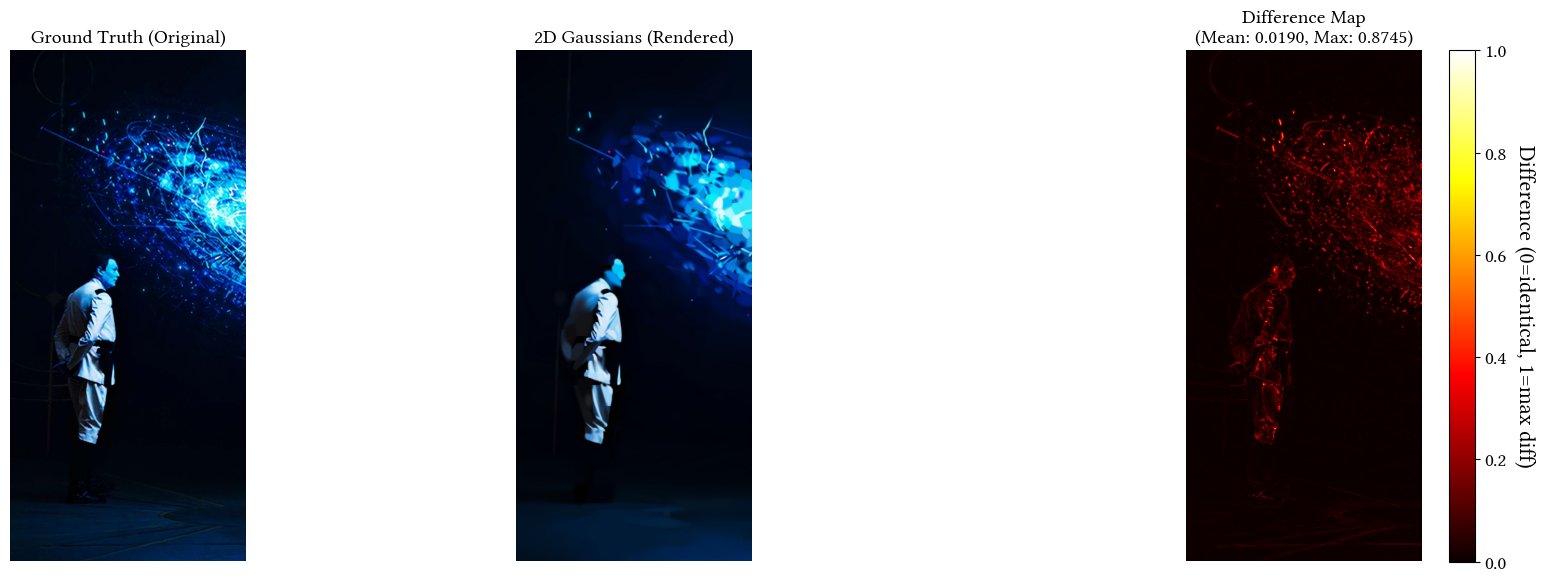

IMAGE-GS TRAINING SUMMARY

TRAINING CONFIGURATION
----------------------------------------------------------------------------------------------------
Input Image:          media/images/thrawn.jpg
Experiment Name:      thrawn
Number of Gaussians:  1000
Max Steps:            7500
Progressive Optim:    False

IMAGE COMPARISON TABLE
METRIC               ORIGINAL           2DGS MODEL         2DGS RENDERED      MODEL RATIO  RENDER RATIO
----------------------------------------------------------------------------------------------------
Width (px)           1080               —                  1080               —            1.00x       
Height (px)          2340               —                  2340               —            1.00x       
Total Pixels         2,527,200          —                  2,527,200          —            1.00x       
Channels             3                  —                  3                  —            1.00x       
File Size            263.85 KB          58.37 K

<Figure size 640x480 with 0 Axes>

In [90]:
# ============================================================
# VIEW RESULTS
# ============================================================
view_results(
  exp_name=EXP_NAME,
  input_image=INPUT_IMAGE,
  num_gaussians=NUM_GAUSSIANS,
  max_steps=MAX_STEPS,
  use_progressive=USE_PROGRESSIVE,
  save_results=True  # Set to False to skip saving
)